# Data Preprocessing 

Based on findings from `01_explore_data.ipynb`, implementing comprehensive preprocessing pipeline.

## Preprocessing Steps

During one pass over the data, we will do the following preprocessing steps.

1. **Convert pseudo-RGB to grayscale** (automatic with cv2.IMREAD_GRAYSCALE)
2. **Resize to 224×224 pixels** (standardize for CNN input)
3. **Apply CLAHE** (enhance contrast + normalize quality variations)

Then, we can focus on some further cleanup after the initial preprocessing is complete.

4. **Remove duplicates** (if found during processing)
5. **Create train/val/test splits** (this is already done for us in the Kaggle dataset)
6. **Address class imbalance** (augmentation for no_tumor class)

**Note:** Outlier removal skipped - CLAHE normalizes quality variations.

In [1]:
import logging

# Configure basic logging to a file
logging.basicConfig(
    filename='duplicates.log',  # Name of the log file
    level=logging.INFO,  # Minimum logging level to capture (INFO, DEBUG, WARNING, ERROR, CRITICAL)
    format='%(asctime)s - %(levelname)s - %(message)s',  # Format of log messages
    filemode='a'  # 'a' for append (default), 'w' for overwrite
)


## Preprocessing Steps 1-5

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import pandas as pd
import hashlib
from sklearn.model_selection import train_test_split
import json

In [3]:
# Preprocessing configuration
config = {
    'target_size': (224, 224),
    'apply_clahe': True,
    'clahe_clip_limit': 2.0,
    'clahe_tile_size': (8, 8),
    'random_seed': 42
}

# Paths
raw_dataset = Path("../data/brain_tumor_dataset")
processed_dataset = Path("../data/processed")

# Splits & Classes
splits = ['Training','Testing']
classes = ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']

print("Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

Configuration:
  target_size: (224, 224)
  apply_clahe: True
  clahe_clip_limit: 2.0
  clahe_tile_size: (8, 8)
  random_seed: 42


In [4]:
image_hashes = {}

In [5]:
def get_image_hash(image_path):
    """Compute Perceptual Hash of an image"""

    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)

    if img is None:
        raise ValueError(f"Failed to read image: {img}")

    img_hash = cv2.img_hash.pHash(img).tobytes()

    return img_hash

In [6]:
def preprocess_image(img_path, target_size=(224,224), equalization=True):
    """
    Apply all preprocessing steps to a single image.
    
    Args:
        img_path: Path to input image
        target_size: Target image size (height, width)
        hist_normalization: Whether to apply histogram equalization
        
    Returns:
        Preprocessed grayscale image (numpy array)
    """

    # read image as grayscale
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)

    if img is None:
            raise ValueError(f"Failed to read image: {img_path}")
    
    # resize so all images are the same size
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_CUBIC)

    # apply clahe equalization
    if equalization:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img = clahe.apply(img)
        
    return img

    

In [7]:
def preprocess_and_save_dataset(raw_dir, target_dir, config, visualize_n_duplicates=0):
    """
    Process entire raw dataset and save to new folder
    
    Args:
        raw_dir: Path to raw dataset
        target_dir: Path to save preprocessed dataset
        config: Dictionary with preprocessing parameters

    Returns:
        Dictionary with processing statistics
    """

    raw_path = Path(raw_dir)
    target_path = Path(target_dir)

    if not target_path.exists():
        os.makedirs(target_path)

    duplicate_example = 0

    # total images counts all images processed
    # class_counts is a dictionary that holds image counts per class
    stats = {'total_images': 0, 'class_counts': {}, 'duplicate_count': 0}    

    for split in splits:
        print(f"Processing {split} set...")
        
        for cls in classes:
            class_path_raw = raw_path / split / cls
            class_path_target = target_path / split / cls

            # iterate through each class folder
            for filename in os.listdir(class_path_raw):

                # skip hidden files and non-image files
                if filename.startswith('.') or not filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                    continue


                img_path_raw = class_path_raw / filename
                img_path_target = class_path_target / filename

                # preprocess image
                img = preprocess_image(img_path_raw,
                                    target_size=config['target_size'],
                                    equalization=config['apply_clahe']
                )

                # compute image hash for duplicate detection
                img_hash = get_image_hash(img_path_raw)

                # check for duplicates
                if img_hash in image_hashes.keys():
                    stats['duplicate_count'] += 1
                    logging.info(f"Duplicate found: {img_path_raw} is a duplicate of {image_hashes[img_hash]}")

                    # visualize duplicates if requested
                    if visualize_n_duplicates > 0 and duplicate_example < visualize_n_duplicates:

                        duplicate_example += 1
                        img1 = cv2.imread(str(img_path_target), cv2.IMREAD_GRAYSCALE) # current image
                        img2 = cv2.imread(str(image_hashes[img_hash]), cv2.IMREAD_GRAYSCALE) # duplicate image

                        plt.figure(figsize=(8,4))
                        plt.suptitle(f"Duplicate Pair {duplicate_example}")

                        plt.subplot(1,2,1)
                        plt.title(f"Image 1: {img_path_target.name}")
                        plt.imshow(img1, cmap='gray')
                        plt.axis('off')

                        plt.subplot(1,2,2)
                        plt.title(f"Image 2: {image_hashes[img_hash].name}")
                        plt.imshow(img2, cmap='gray')
                        plt.axis('off')

                        plt.show()
                    continue

                # save to target folder
                if not class_path_target.exists():
                    os.makedirs(class_path_target)
                target_img_path = class_path_target / filename
                cv2.imwrite(str(target_img_path), img)
                stats['total_images'] += 1
                if cls not in stats['class_counts']:
                    stats['class_counts'][cls] = 0
                stats['class_counts'][cls] += 1

                # store image hash
                image_hashes[img_hash] = img_path_target # key: image hash, value: target filepath

    return stats

Processing Training set...


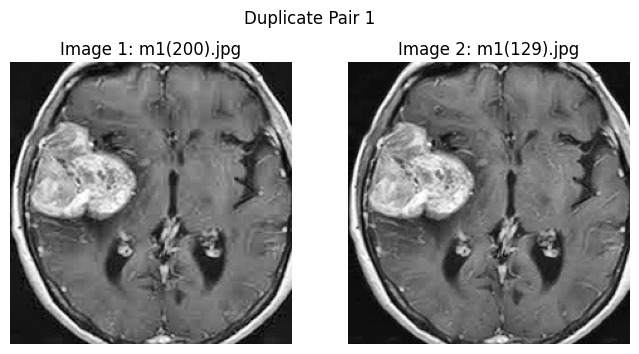

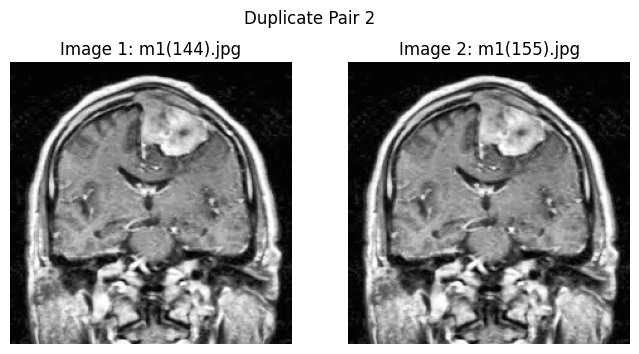

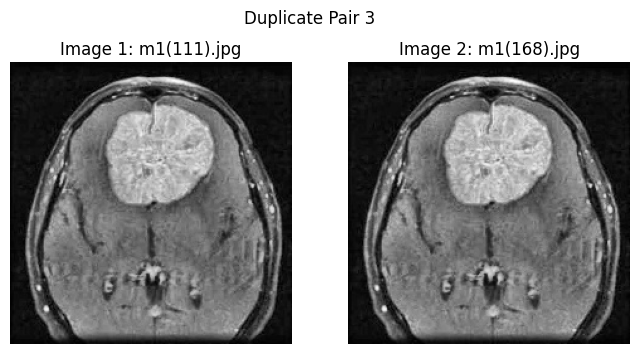

Processing Testing set...
Preprocessing complete!
Total images processed: 2851
Total duplicates found and skipped: 112
  glioma_tumor: 883 images
  meningioma_tumor: 816 images
  pituitary_tumor: 832 images
  no_tumor: 320 images


In [8]:
stats = preprocess_and_save_dataset(raw_dataset, processed_dataset, config, visualize_n_duplicates=3)
print("Preprocessing complete!")
print(f"Total images processed: {stats['total_images']}")
print(f"Total duplicates found and skipped: {stats['duplicate_count']}")
for cls, count in stats['class_counts'].items():
    print(f"  {cls}: {count} images")


In [9]:
def visualize_preprocessing_effects(sample_image_path):
    """
    Visualize the effects of preprocessing on a sample image.
    Args:
        sample_image_path: Path to a sample raw image
    Returns:
        None
    """

    raw_img = cv2.imread(str(sample_image_path), cv2.IMREAD_GRAYSCALE)

    preprocessed_img = preprocess_image(sample_image_path,
                                    target_size=config['target_size'],
                                    equalization=config['apply_clahe']
    )

    plt.figure(figsize=(8,4))
    plt.suptitle(f"Preprocessing Effects on: {sample_image_path.name}")
    plt.subplot(1, 2, 1)
    plt.title("Raw Image")
    plt.imshow(raw_img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Preprocessed Image")
    plt.imshow(preprocessed_img, cmap='gray')
    plt.axis('off')

    plt.show()

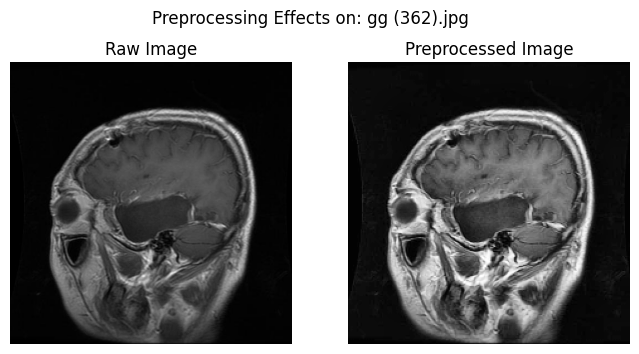

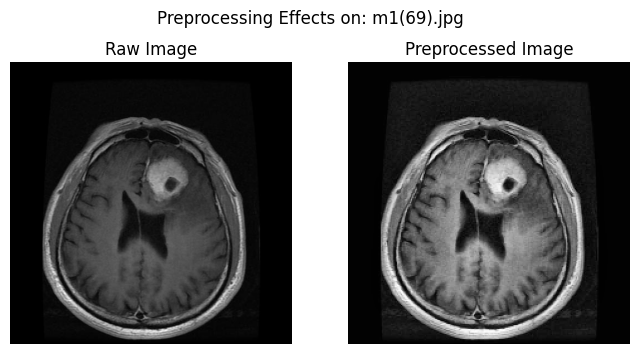

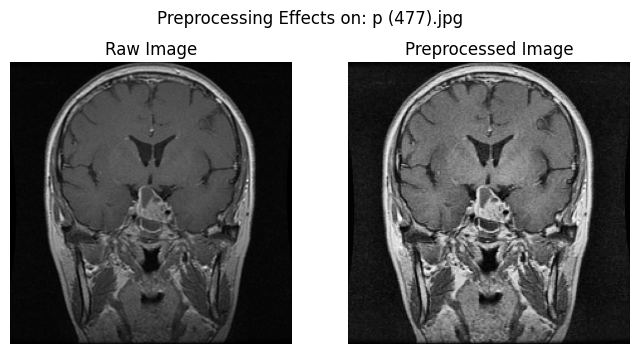

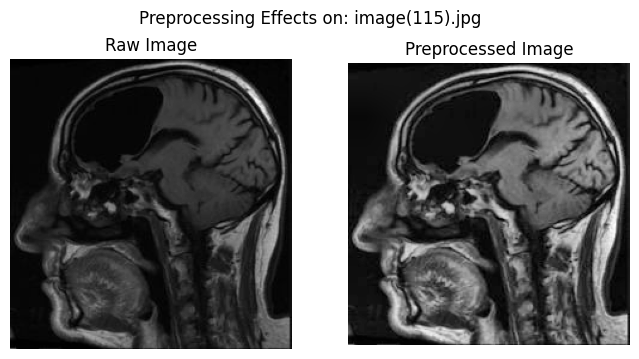

In [10]:
# show a few examples of preprocessed images before & after
def display_preprocessed_examples(raw_dir, processed_dir, classes, num_examples=3):
    raw_path = Path(raw_dir)
    processed_path = Path(processed_dir)

    for cls in classes:
        class_path_raw = raw_path / 'Training' / cls
        class_path_processed = processed_path / 'Training' / cls

        example_files = os.listdir(class_path_raw)[:num_examples]

        for filename in example_files:
            raw_img_path = class_path_raw / filename
            visualize_preprocessing_effects(raw_img_path)

display_preprocessed_examples(raw_dataset, processed_dataset, classes, num_examples=1)